In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [16]:
warnings.filterwarnings('ignore')

In [17]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [18]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,temp_dp_interaction_evening_X_doy_sin_sq,temp_dp_interaction_evening_X_doy_cos_sq,temp_dp_interaction_morning_X_doy_cos_sq,STA_x_slp_X_doy_sin_sq,STA_x_slp_X_doy_cos_sq,clim_doy_sin_X_slp_avg_base,clim_doy_sin_slp_X_doy_cos,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,0.029615,99.920107,127.438895,-0.881541,-2974.285840,-48.202603,-48.195461,119598.77325,-805.468750,-3.558264e+08
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,0.123110,103.780224,139.827463,-2.595330,-2187.838376,-129.926788,-129.849793,119683.07950,-775.016667,-2.621579e+08
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,0.269383,100.828117,124.610965,-7.249960,-2713.603741,-144.110419,-143.918294,119787.61925,-808.470833,-3.259246e+08
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,0.087480,18.392520,95.585368,-6.930954,-1457.218729,-177.599760,-177.178902,119294.78900,-297.733333,-1.746654e+08
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,0.865034,116.190521,82.468249,-5.823838,-782.251995,-231.959085,-231.100413,118848.68850,-814.372222,-9.366178e+07


# Dataset Splitting

In [19]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [20]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 52,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [21]:
# study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
# study.optimize(objective, n_trials=30, n_jobs=10)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")
#
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'random_state': 52,
#     'verbosity': 0
# })

In [25]:
best_params = {'n_estimators': 6000, 'learning_rate': 0.04301669654154669, 'max_depth': 6, 'subsample': 0.686853543077099, 'colsample_bytree': 0.6974010880163497, 'min_child_weight': 0.15793160713168192, 'gamma': 7.333260919965793e-08, 'reg_alpha': 0.005971371924073574, 'reg_lambda': 0.025035399359745195}

# Fit

In [26]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.8149 | RMSE: 1.2883


# Feature Importance

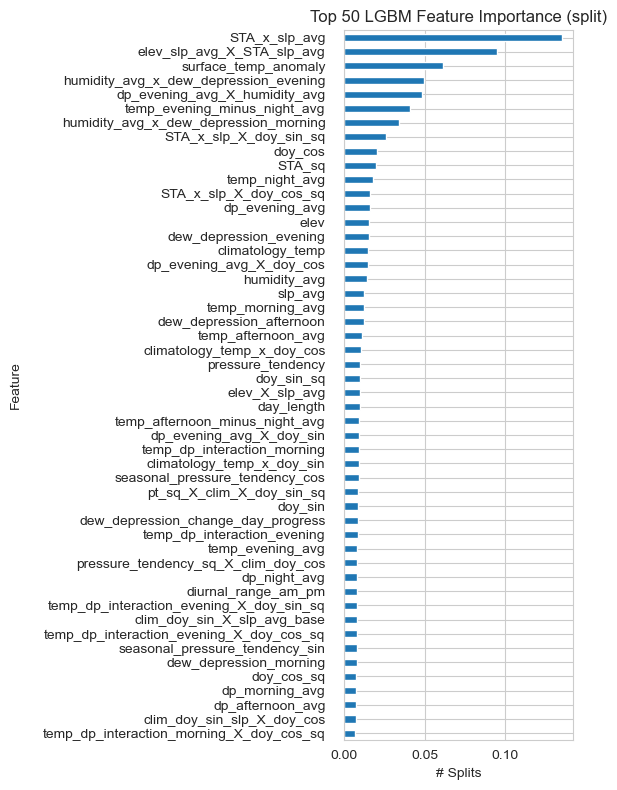

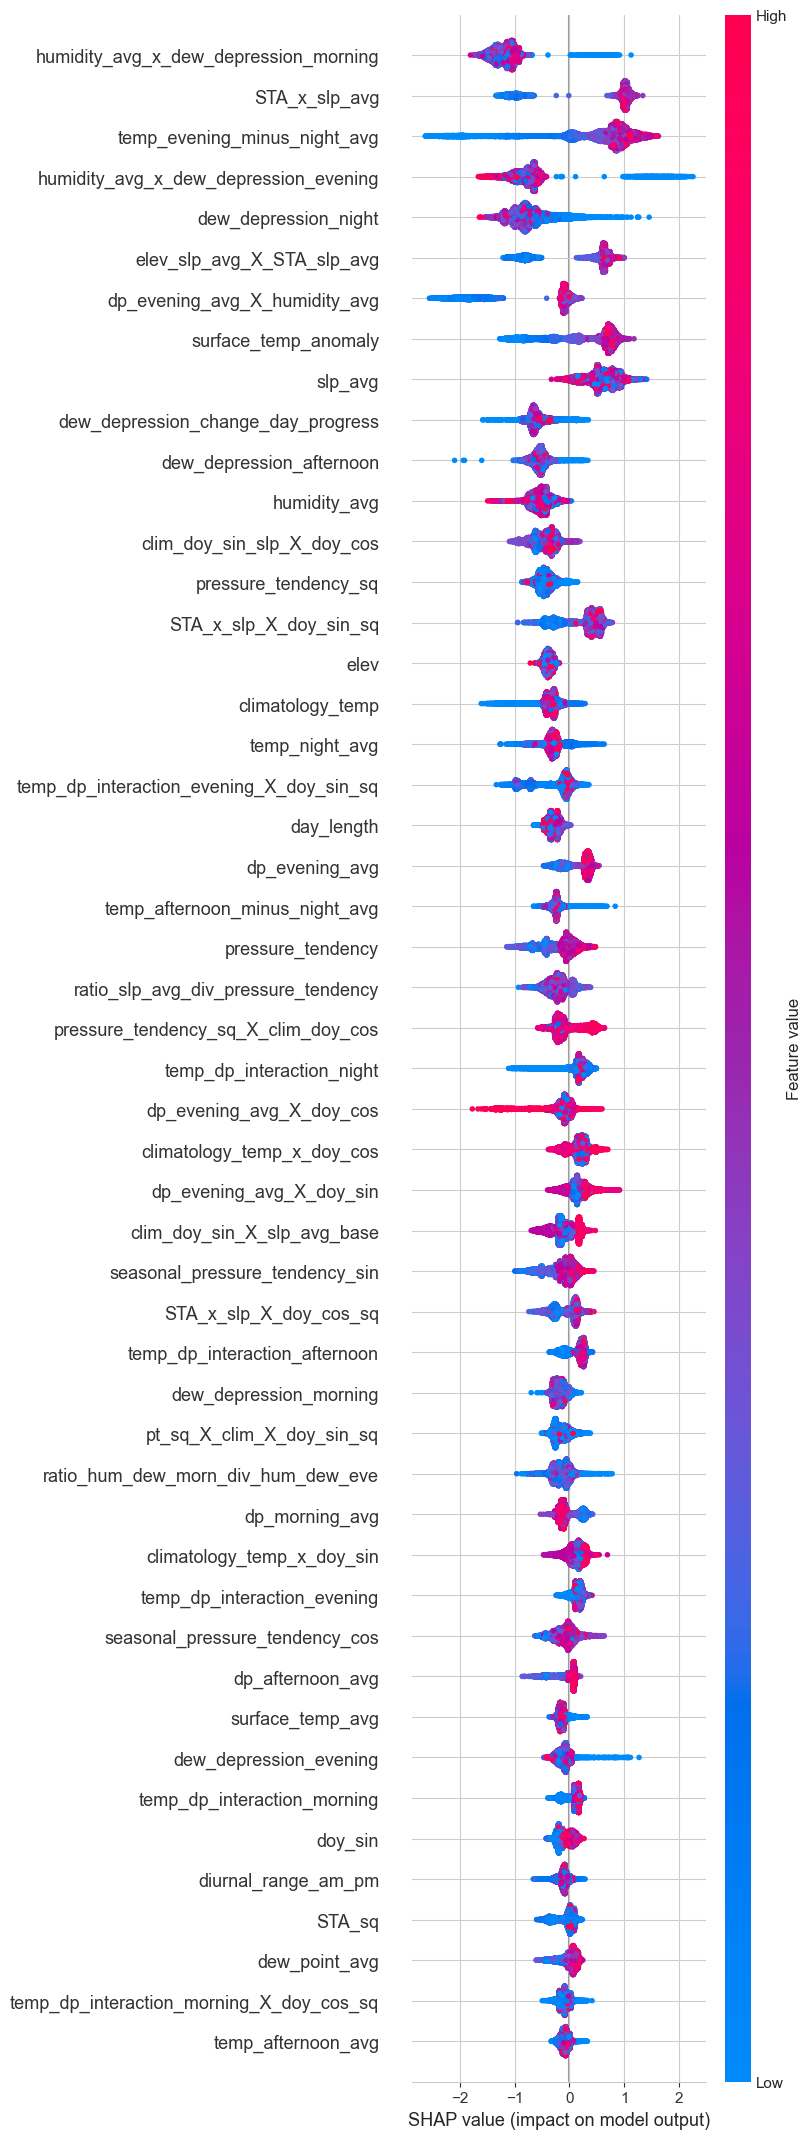

In [12]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N} LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [13]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 XGB Importances (split):
STA_x_slp_avg                               0.135817
elev_slp_avg_X_STA_slp_avg                  0.095311
surface_temp_anomaly                        0.061531
humidity_avg_x_dew_depression_evening       0.049709
dp_evening_avg_X_humidity_avg               0.048620
temp_evening_minus_night_avg                0.040971
humidity_avg_x_dew_depression_morning       0.034244
STA_x_slp_X_doy_sin_sq                      0.026197
doy_cos                                     0.020455
STA_sq                                      0.019711
temp_night_avg                              0.017746
STA_x_slp_X_doy_cos_sq                      0.015960
dp_evening_avg                              0.015749
elev                                        0.015482
dew_depression_evening                      0.015129
climatology_temp                            0.014925
dp_evening_avg_X_doy_cos                    0.014803
humidity_avg                                0.013868
slp_avg       

# Feature Selection with SHAP

In [14]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
dew_depression_afternoon                    0.552339
humidity_avg                                0.525103
clim_doy_sin_slp_X_doy_cos                  0.466962
pressure_tendency_sq                        0.430824
STA_x_slp_X_doy_sin_sq                      0.400532
elev                                        0.386359
climatology_temp                            0.373649
temp_night_avg                              0.309168
temp_dp_interaction_evening_X_doy_sin_sq    0.300814
day_length                                  0.286796
dp_evening_avg                              0.268811
temp_afternoon_minus_night_avg              0.251025
pressure_tendency                           0.245018
ratio_slp_avg_div_pressure_tendency         0.231556
pressure_tendency_sq_X_clim_doy_cos         0.229204
temp_dp_interaction_night                   0.227859
dp_evening_avg_X_doy_cos                    0.207696
climatology_temp_x_doy_cos                  0.196569
dp_evening_avg_X_doy_

# Predict with Test Dataset

In [28]:
y_test_pred = xgb_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_{now}.csv', index=False)